In [9]:
# KEY IDEA: an algorithm should explore arms more often if they are...
#
#   (a) promising, based on a large empirical mean \hat(mu)(t-1)
#   (b) not well explored, i.e., T_i(t-1) is small (arm has not been picked often)

# An ""INDEX ALGORITHM"" chooses the arm in each round that maximises some value
# (the ""INDEX"" of the set of arms) which depends on the time step and the samples
# from that arm

# The Upper confidence bound (UCB(\delta)) sets the index of an arm as the sum of 
# the empirical mean and the so-called ""EXPLORATION BONUS"", which is
# the confidence width of the arm.

# As with most algorithms, there is an art in choosing a satisfactory value of 
# the value of the confidence level, \delta.

# EXERCISE 7.8: empirical comparison
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [10]:
# Again define the Gaussian bandit (just being lazy and copy-pasting)
class Gaussian_Bandit:
    
    # Accept a list of K >= 2 floats, representing means of
    # Gaussian distributions for each bandit arm
    def __init__(self,means):
        self.bandit_means = means
        self.rand_regret = 0
        self.pseudo_rand_regret = 0
        self.best_mean = max(self.bandit_means)
    
    # Function that returns the number of bandit arms
    def K(self):
        return len(self.bandit_means)
    
    # Accepts a parameter 0 <= a <= K-1 and returns the
    # realization of random variable X with P(X=1) being the
    # mean of the (a+1)^th arm.
    def pull(self,a):
        selected_arm_mean = self.bandit_means[a]
        selected_arm_sample = norm.rvs(loc=selected_arm_mean,size=1)
        self.rand_regret = self.rand_regret + (self.best_mean - selected_arm_sample)
        self.pseudo_rand_regret = self.pseudo_rand_regret + (self.best_mean - selected_arm_sample)
        return selected_arm_sample
    
    # Returns the regret incurred so far.
    def random_regret(self):
        return self.rand_regret
    
    def pseudo_random_regret(self):
        return self.pseudo_rand_regret

In [19]:
# Define the UCB algorithm
def UCB_algorithm(n,bandit):

    arm_sample_sums = np.zeros((bandit.K(),1))
    arm_sample_means = np.zeros((bandit.K(),1))
    arm_values_T = np.zeros((bandit.K(),1))
    arm_indices = np.zeros((bandit.K(),1))
    
    # First, test the value of each arm once (tie break as default is \infty)
    for i in range(bandit.K()):
        arm_sample_sums[i] += bandit.pull(i)
        arm_values_T[i] += 1
        arm_sample_means[i] = (1/arm_values_T[i])*arm_sample_sums[i]
    
    # Over the remaining time horizon, choose the arm with the optimal index
    for i in range(n-bandit.K()):
        
        # Need to account for fact already sampled twice and that
        # Python starts indexing from zero.
        lc_delta = (1/(i+3))**2 
        
        # Compute current arm index for each arm
        for j in range(bandit.K()):
            arm_indices[j] = arm_sample_means[j] + np.sqrt(2*np.log2(1/lc_delta)/arm_values_T[j])
        
        # Obtain the optimal arm index
        optimal_arm = np.argmax(arm_indices)
        # Sample the arm with the optimal index
        sample = bandit.pull(optimal_arm)
        # Iterate the number of times that the arm has been chosen
        arm_values_T[optimal_arm] += 1
        # Recalculate the arm sample mean
        arm_sample_sums[optimal_arm] += sample
        arm_sample_means[optimal_arm] = (1/arm_values_T[optimal_arm])*arm_sample_sums[optimal_arm]
        
    return bandit.rand_regret

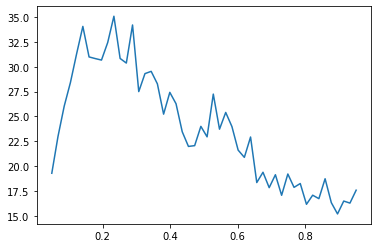

In [33]:
# (a): Implement Algorithm 3 on page 102 (do only for UCB, refer to previous to
# compare to ETC algorithms).

def main():
    num_delta_vals = 50
    num_tr_per_del = 500
    n = 1000
    delta_vals = np.linspace(0.05,0.95,num_delta_vals)
    regrets = np.zeros((num_delta_vals,1))
    for i in range(num_delta_vals):
        for j in range(num_tr_per_del):
            cur_delta = delta_vals[i]
            K = [0,cur_delta]
            cur_bandit = Gaussian_Bandit(K)
            regrets[i] += UCB_algorithm(n,cur_bandit)
    regrets = (1/num_tr_per_del)*regrets[:]
    
    plt.figure()
    plt.plot(delta_vals,regrets)

if __name__ == "__main__":
    main()